# Problem statement - Given the set of independent features, the model needs to predict whether the student will get Placed OR Not

# Deciding on the right metric for the problem statement - Since, there's no serious impact on anything in case of wrong predictions, we can decide on f1-score OR roc_auc_score as the right metric for this problems. f1-score balances both "precision" & "recall" whereas "roc_auc_score" is considered the "all weather right metric" for classification problems.

In [2]:
# Importing all the dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
from sklearn.model_selection import cross_val_score,train_test_split,GridSearchCV
from sklearn.feature_selection import chi2,mutual_info_classif
import shap
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Importing data from my local system
df=pd.read_csv('Placement_Data_Full_Class.csv')

In [4]:
# Checking the first 5 rows
df.head()

,sl_no,gender,ssc_p,ssc_b,hsc_p,hsc_b,hsc_s,degree_p,degree_t,workex,etest_p,specialisation,mba_p,status,salary
0,1,M,67.00,Others,91.00,Others,Commerce,58.00,Sci&Tech,No,55.0,Mkt&HR,58.80,Placed,270000.0
1,2,M,79.33,Central,78.33,Others,Science,77.48,Sci&Tech,Yes,86.5,Mkt&Fin,66.28,Placed,200000.0
2,3,M,65.00,Central,68.00,Central,Arts,64.00,Comm&Mgmt,No,75.0,Mkt&Fin,57.80,Placed,250000.0
3,4,M,56.00,Central,52.00,Central,Science,52.00,Sci&Tech,No,66.0,Mkt&HR,59.43,Not Placed,NaN
4,5,M,85.80,Central,73.60,Central,Commerce,73.30,Comm&Mgmt,No,96.8,Mkt&Fin,55.50,Placed,425000.0


In [5]:
# Checking the shape of the dataset
df.shape

In [6]:
# Information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215 entries, 0 to 214
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   sl_no           215 non-null    int64  
 1   gender          215 non-null    object 
 2   ssc_p           215 non-null    float64
 3   ssc_b           215 non-null    object 
 4   hsc_p           215 non-null    float64
 5   hsc_b           215 non-null    object 
 6   hsc_s           215 non-null    object 
 7   degree_p        215 non-null    float64
 8   degree_t        215 non-null    object 
 9   workex          215 non-null    object 
 10  etest_p         215 non-null    float64
 11  specialisation  215 non-null    object 
 12  mba_p           215 non-null    float64
 13  status          215 non-null    object 
 14  salary          148 non-null    float64
dtypes: float64(6), int64(1), object(8)
memory usage: 25.3+ KB


### Initial Observations
### 1. Data belongs to a set of students who have attended the campus interviews. Target variable is "status"
### 2. There are a total of 15 columns - 6 float columns, 1 integer column & 8 object type columns
### 3. Dataset has a total of 215 datapoints/observations

In [7]:
df['sl_no'].nunique()

215

## Important 1 - Problem statement is to predict the interview status i.e. whether he/she has got placed or not placed. With this statement, "salary" column will not contribute anything to the prediction & this is discussed after getting placed. Hence, dropping it from the dataset
## Important 2 - Looks like 'sl_no' is an identifier column which will not value add anything to the prediction, hence, dropping this too from the dataset

In [8]:
# Dropping sl_no & salary columns
df.drop(columns=['sl_no','salary'],inplace=True)

In [9]:
# cross-checking the effect of the previous step
df.head()

,gender,ssc_p,ssc_b,hsc_p,hsc_b,hsc_s,degree_p,degree_t,workex,etest_p,specialisation,mba_p,status
0,M,67.00,Others,91.00,Others,Commerce,58.00,Sci&Tech,No,55.0,Mkt&HR,58.80,Placed
1,M,79.33,Central,78.33,Others,Science,77.48,Sci&Tech,Yes,86.5,Mkt&Fin,66.28,Placed
2,M,65.00,Central,68.00,Central,Arts,64.00,Comm&Mgmt,No,75.0,Mkt&Fin,57.80,Placed
3,M,56.00,Central,52.00,Central,Science,52.00,Sci&Tech,No,66.0,Mkt&HR,59.43,Not Placed
4,M,85.80,Central,73.60,Central,Commerce,73.30,Comm&Mgmt,No,96.8,Mkt&Fin,55.50,Placed


## Exploratory Data Analysis

In [10]:
# Creating the list of "object" type columns
cat_cols=df.select_dtypes('object').columns

In [11]:
cat_cols

Index(['gender', 'ssc_b', 'hsc_b', 'hsc_s', 'degree_t', 'workex',
       'specialisation', 'status'],
      dtype='object')

In [12]:
# Creating the list of "numerical" columns
num_cols=df.select_dtypes('float').columns

In [13]:
# printing the unique values of categorical columns
for i in cat_cols:
    print(i,df[i].unique())

gender ['M' 'F']
ssc_b ['Others' 'Central']
hsc_b ['Others' 'Central']
hsc_s ['Commerce' 'Science' 'Arts']
degree_t ['Sci&Tech' 'Comm&Mgmt' 'Others']
workex ['No' 'Yes']
specialisation ['Mkt&HR' 'Mkt&Fin']
status ['Placed' 'Not Placed']


In [14]:
# Statistical Summary of all the numerical columns
df[num_cols].describe()

,ssc_p,hsc_p,degree_p,etest_p,mba_p
count,215.000000,215.000000,215.000000,215.000000,215.000000
mean,67.303395,66.333163,66.370186,72.100558,62.278186
std,10.827205,10.897509,7.358743,13.275956,5.833385
min,40.890000,37.000000,50.000000,50.000000,51.210000
25%,60.600000,60.900000,61.000000,60.000000,57.945000
50%,67.000000,65.000000,66.000000,71.000000,62.000000
75%,75.700000,73.000000,72.000000,83.500000,66.255000
max,89.400000,97.700000,91.000000,98.000000,77.890000


### Univariate Analysis

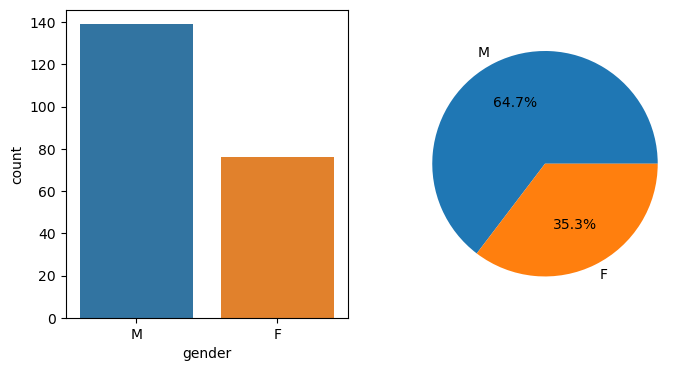

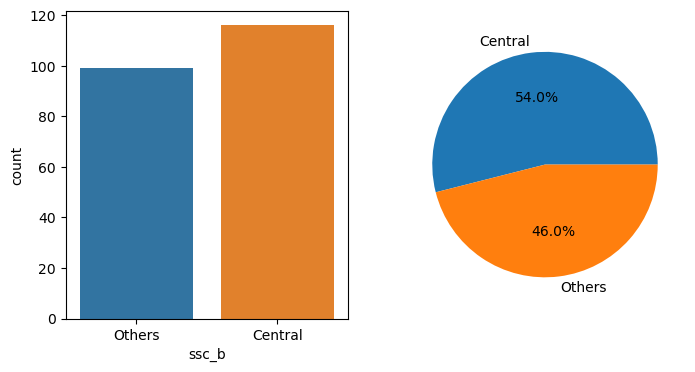

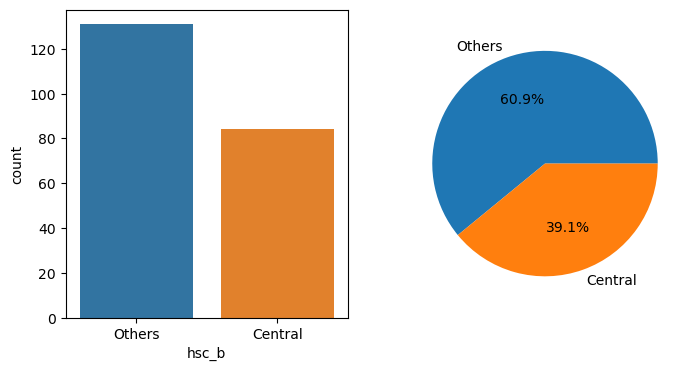

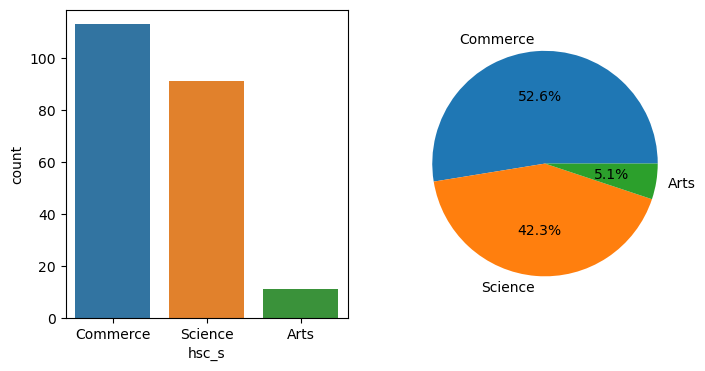

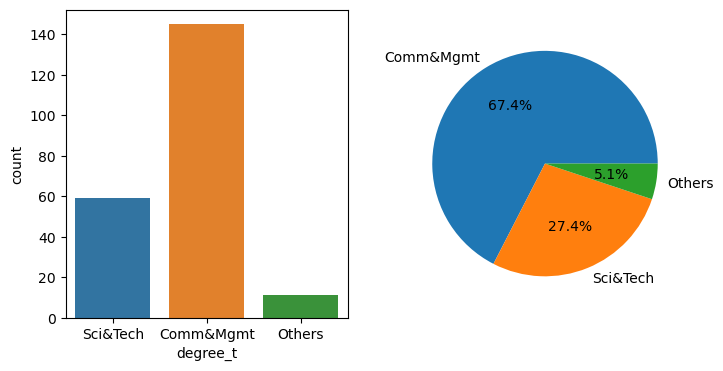

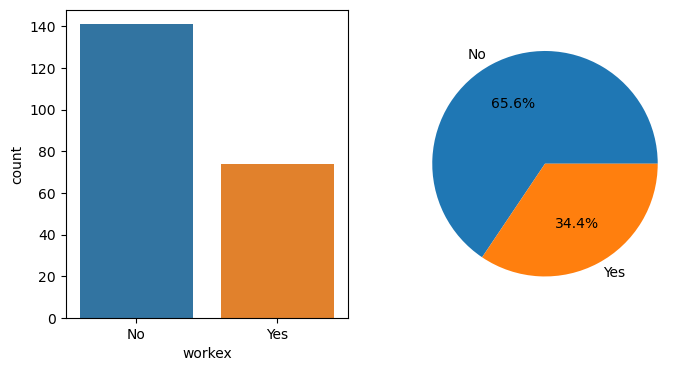

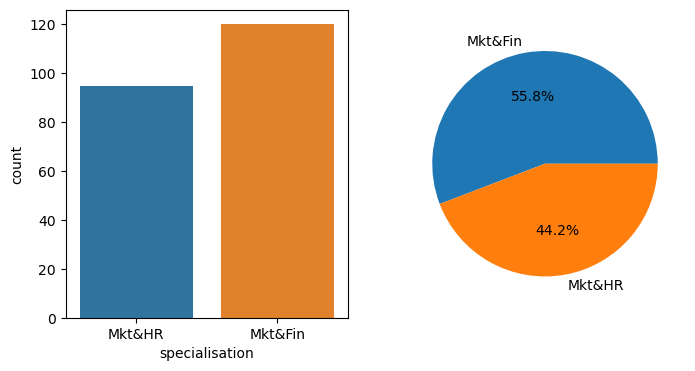

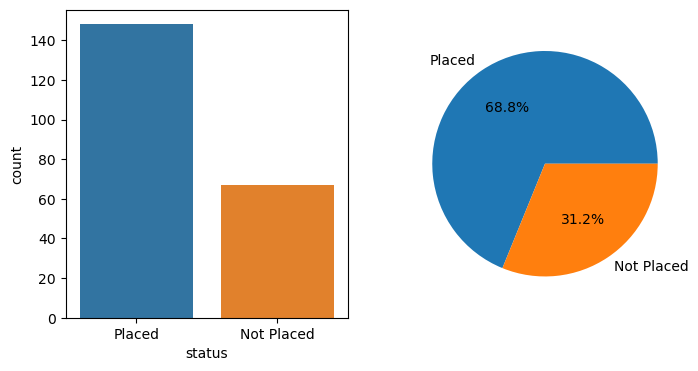

In [15]:
# Univariate analysis of categorical variables
for i in cat_cols:
    plt.figure(figsize=(8,4))
    plt.subplot(121)
    sns.countplot(x=i,data=df)
    plt.subplot(122)
    plt.pie(df[i].value_counts().values,labels=df[i].value_counts().index,autopct='%1.1f%%')
    plt.show();

### Observations from categorical variables of the dataset
### 1. Majority of the students are males with almost 65% of the totals
### 2. Not major difference in the no of students with central or other boards for Secondary Education is noticed however central board students are little more than others board of education
### 3. For higher secondary education, there are more no of people from others board than central board students. Almost 61% of students are from others board for HSC
### 4. More than half of the students are from commerce background for higher secondary education followed by science background & arts background
### 5. Almost 68% of the students have their degrees in 'Comm&Mgmt' followed by 'Sci&Tech' & 'Others'
### 6. Around 65% of the students have no prior work experience which means all of these students have not worked after the completion of their degrees
### 7. Majority (56%) of the students are from 'Mkt&Fin' specialization & the rest (44%) from 'Mkt&HR' specialization
### 8. Their placement percentage is 68% i.e. out of 100 students, 68 students get placed

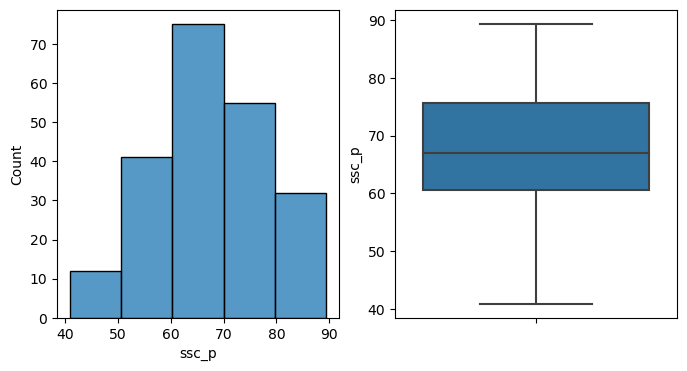

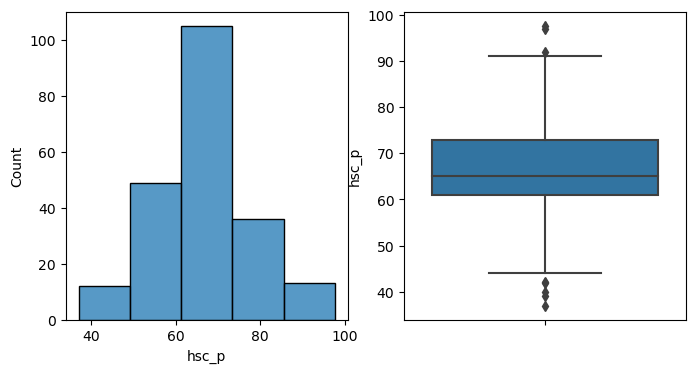

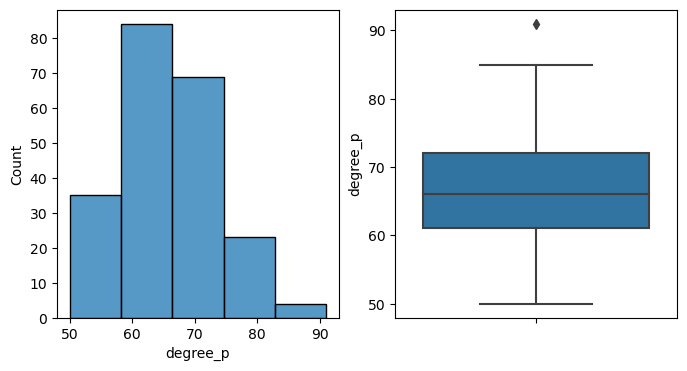

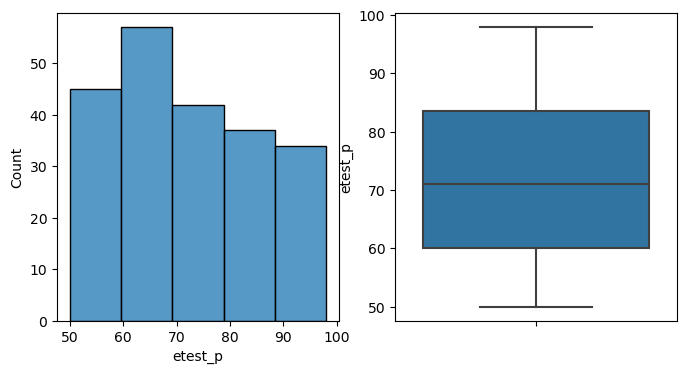

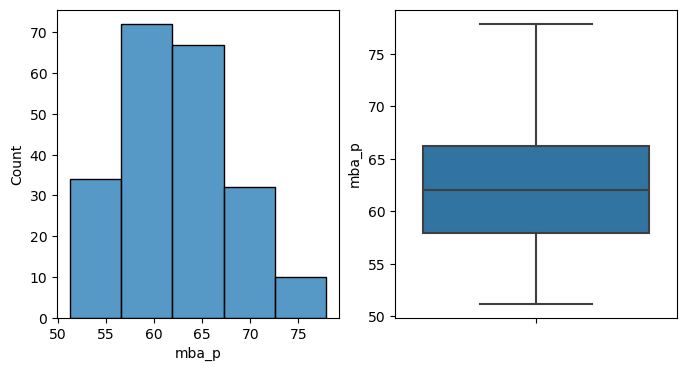

In [16]:
for i in num_cols:
    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    sns.histplot(x=i,data=df,bins=5)
    plt.subplot(1,2,2)
    sns.boxplot(y=i,data=df)
    plt.show();

### Observations from numerical variables
### 9. Big number of students have their ssc scores between 60% to 70% with median ssc percentage of 67
### 10. Big number of students have their hsc scores between 62% to 74% with median hsc percentage of 65
### 11. Big number of students have their degree scores between 58% to 75% with median degree percentage of 66
### 12. Employability scores show almost a uniform distribution i.e. their are almost equal no of people in almost all the buckets of scores between 50 to 100 however little bigger number of people between 59 to 69 as employability percentages & median employability score of 71%
### 13. Majority of the students have their MBA scores between 57% to 67%

### Bivariate Analysis - Categorical Vs target

In [17]:
# Dropping the target variable i.e. 'status' from cat_cols list
cat_cols=cat_cols.drop('status')

In [18]:
# Checking to see if 'status' has been dropped from the list
cat_cols

Index(['gender', 'ssc_b', 'hsc_b', 'hsc_s', 'degree_t', 'workex',
       'specialisation'],
      dtype='object')

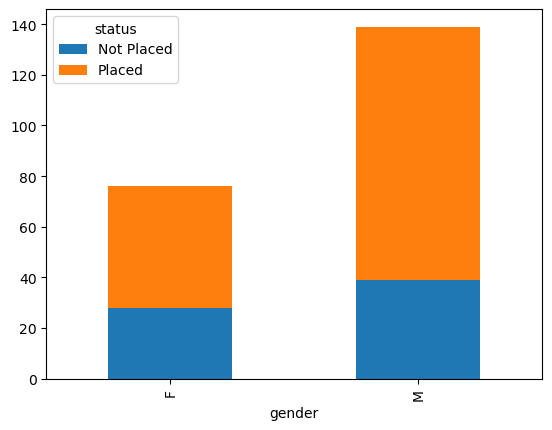

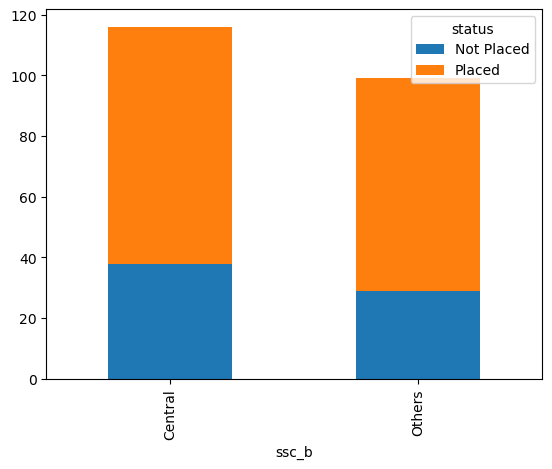

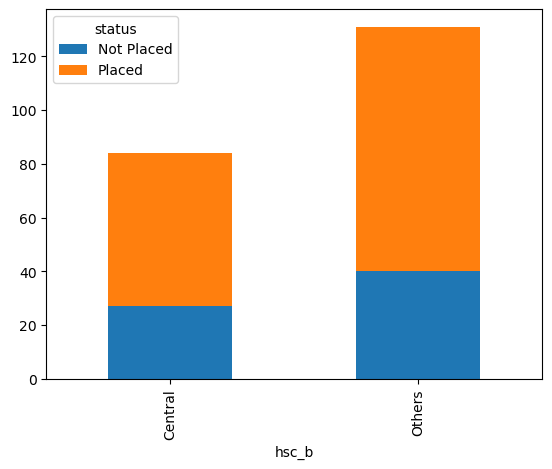

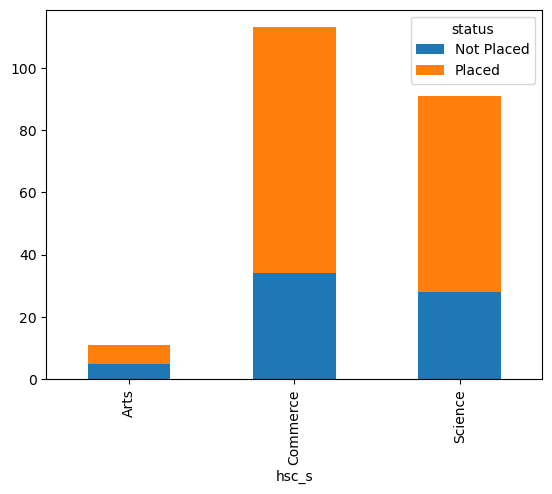

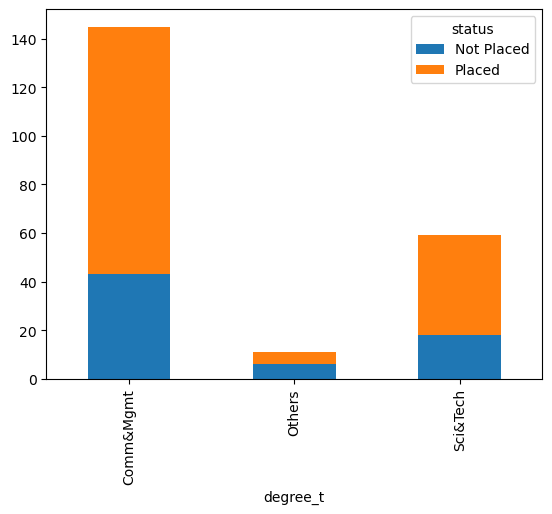

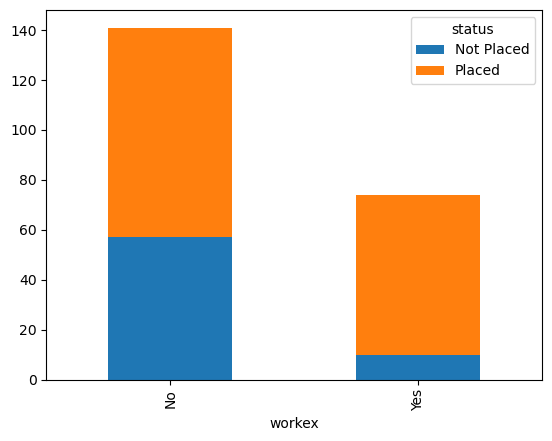

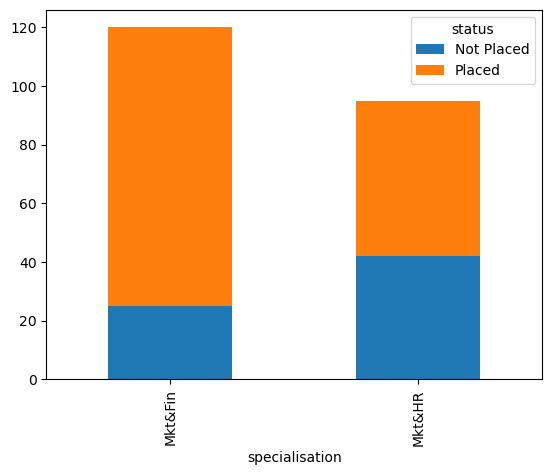

In [19]:
# Bi-variate analysis of categorical variables with the target variable
for i in cat_cols:
    pd.crosstab(df[i],df['status']).plot.bar(stacked=True);

### Observations from Bi-Variate analysis i.e. between categorical variables & the target variable (categorical)
### 14. Many of the placed students are Male i.e. placement percentage is higher amongst Males
### 15. We know that there are slightly higher number of students from central board background for SSC & no major impact or difference is noted in relation to this SSC board with placement
### 16. Students with `others` board of education for HSC are slightly more likely to get placed than `central` board hsc. However there's no major change noticed in this. It is only slightly higher chances for `others` board
### 17. Almost 74% of students from commerce in HSC got placed, almost 66% of students from science in HSC got placed & 50% students from arts in HSC got placed.
### 18. Almost 69% of students from commerce&mgmt in degree got placed, 40% of students from others in degree got placed & almost 68% of students from sci&tech in degree got placed
### 19. Almost 86% of students who have worked before got placed i.e. students with prior work experience are more likely to get placed here in this campus interview. People with no prior experience stand only 60% chance to get placed
### 20. 78% of students from 'marketing&finance' got placed & only 53% of students from 'marketing&HR' got placed

### Bi-Variate Analysis - Continuous/Numerical Vs target

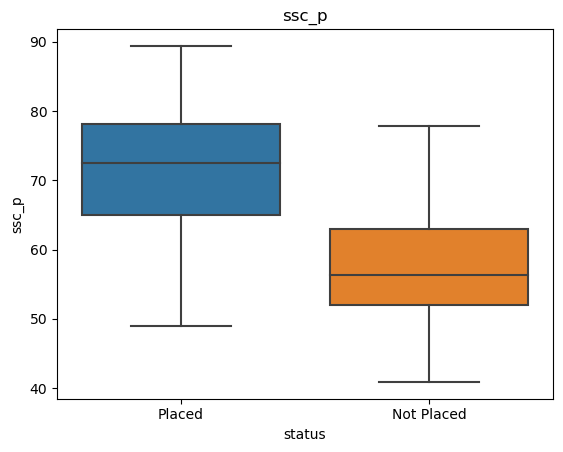

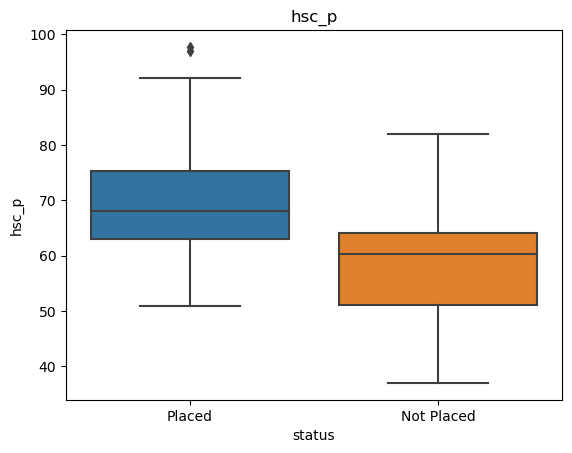

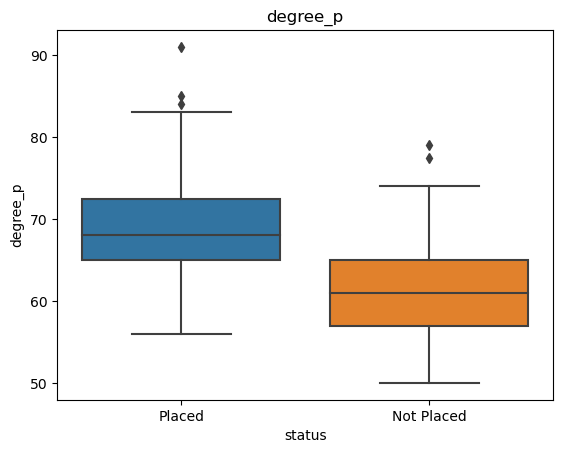

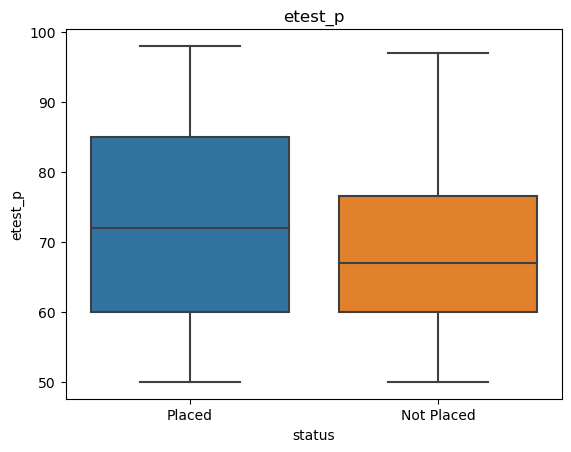

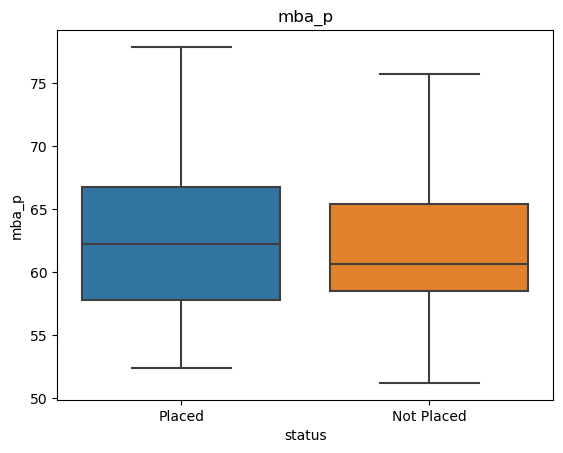

In [20]:
for i in num_cols:
    plt.figure()
    plt.title(i)
    sns.boxplot(y=df[i],x=df['status']);

### Observations from Bi-Variate analysis i.e. between numerical variables & the target variable (categorical)
### 21. median ssc percentage of the students who got placed is close to 73% whereas the median ssc percentage of students who are not placed is 55%. i.e. people with higher ssc percentage are more likely to get placed
### 22. median hsc percentage of the students who got placed is close to 68% whereas the median hsc percentage of students who are not placed is 60%.
### 23. median degree percentage of the students who got placed is close to 68% whereas the median degree percentage of students who are not placed is 61%.
### 24. There's no major difference in median Employability test scores of placed & not placed students. So, it is more likely that this variable might not be helpful in the prediction.
### 25. Even the MBA percentages might not be helpful in the prediction as there's only a minor change in the  median percentages of placed & not placed students.

## Data pre-processing

In [21]:
# Checking for missing values
df.isnull().sum()

gender            0
ssc_p             0
ssc_b             0
hsc_p             0
hsc_b             0
hsc_s             0
degree_p          0
degree_t          0
workex            0
etest_p           0
specialisation    0
mba_p             0
status            0
dtype: int64

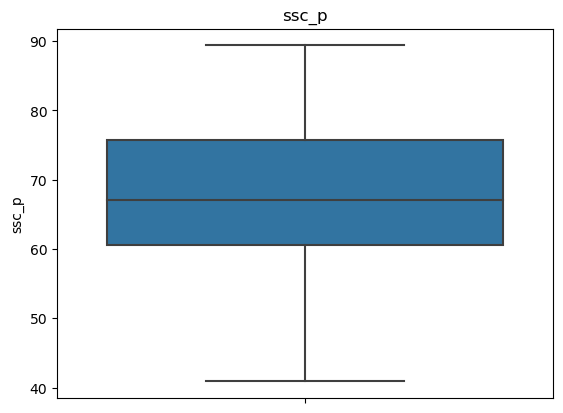

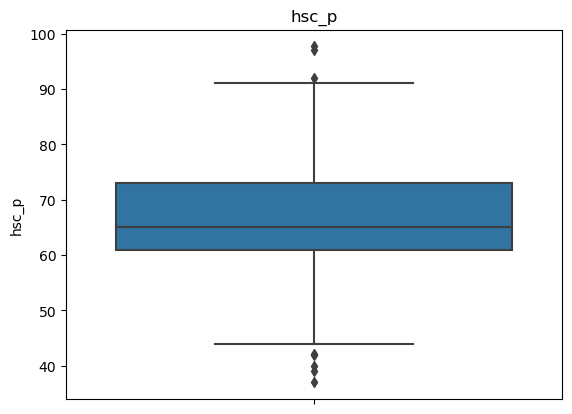

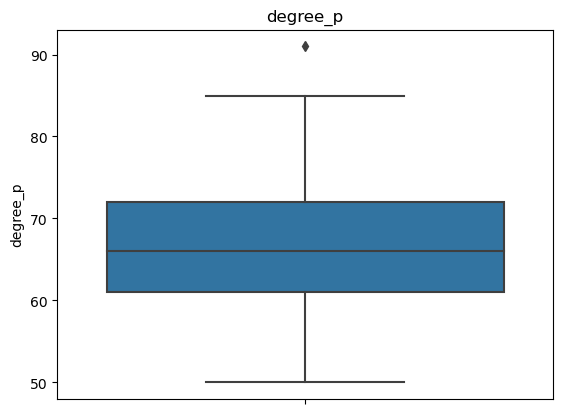

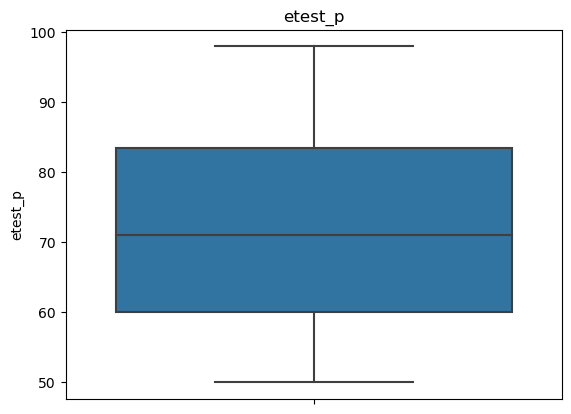

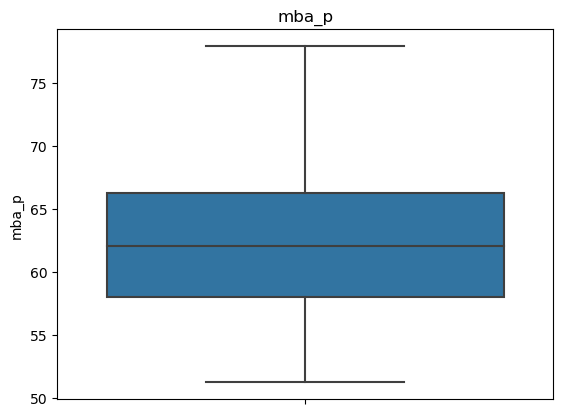

In [22]:
# Checking for outliers
for i in num_cols:
    plt.figure()
    plt.title(i)
    sns.boxplot(y=i,data=df);

In [23]:
# Creating a function for treating the outliers using IQR method
def outlier_treatment(i):
    q3=np.quantile(df[i],0.75)
    q1=np.quantile(df[i],0.25)
    iqr=q3-q1
    uw=q3+(1.5*iqr)
    lw=q1-(1.5*iqr)
    df[i]=np.where(df[i]>uw,uw,df[i])
    df[i]=np.where(df[i]<lw,lw,df[i])

In [24]:
# Treatment is done for the outliers in hsc_p & degree_p columns
for i in ['hsc_p','degree_p']:
    outlier_treatment(i)

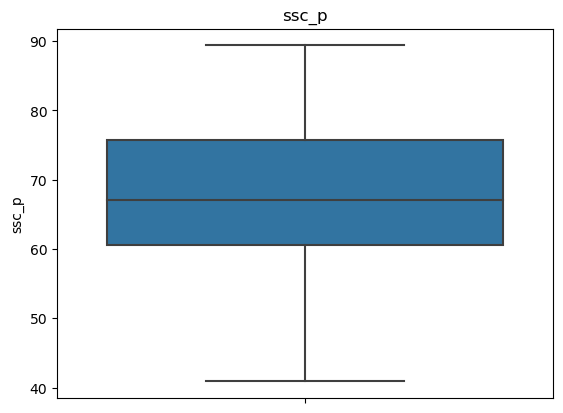

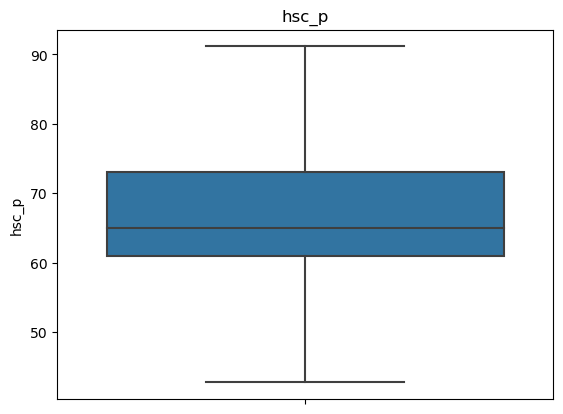

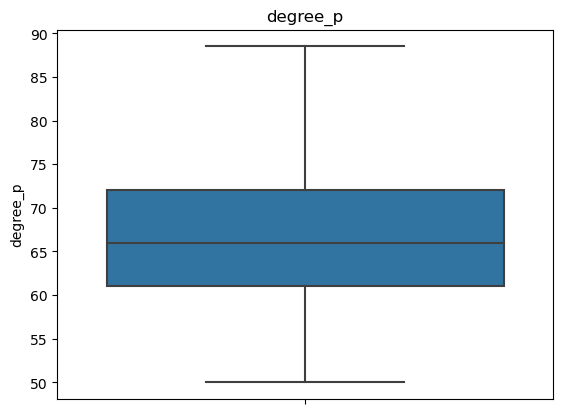

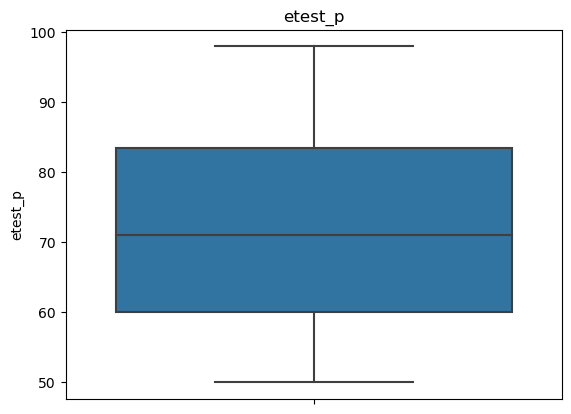

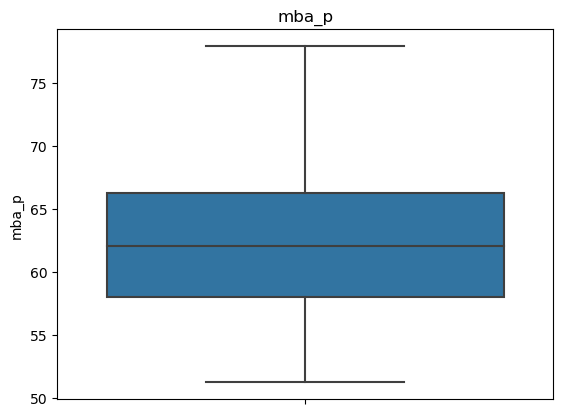

In [25]:
# Re-Checking for outliers & ensuring that there are no outliers
for i in num_cols: 
    plt.figure()
    plt.title(i)
    sns.boxplot(y=i,data=df);

In [26]:
# Checking for duplicate values in the dataset
df[df.duplicated()]

,gender,ssc_p,ssc_b,hsc_p,hsc_b,hsc_s,degree_p,degree_t,workex,etest_p,specialisation,mba_p,status


In [27]:
df.head()

,gender,ssc_p,ssc_b,hsc_p,hsc_b,hsc_s,degree_p,degree_t,workex,etest_p,specialisation,mba_p,status
0,M,67.00,Others,91.00,Others,Commerce,58.00,Sci&Tech,No,55.0,Mkt&HR,58.80,Placed
1,M,79.33,Central,78.33,Others,Science,77.48,Sci&Tech,Yes,86.5,Mkt&Fin,66.28,Placed
2,M,65.00,Central,68.00,Central,Arts,64.00,Comm&Mgmt,No,75.0,Mkt&Fin,57.80,Placed
3,M,56.00,Central,52.00,Central,Science,52.00,Sci&Tech,No,66.0,Mkt&HR,59.43,Not Placed
4,M,85.80,Central,73.60,Central,Commerce,73.30,Comm&Mgmt,No,96.8,Mkt&Fin,55.50,Placed


In [28]:
for i in cat_cols:
    print(i,df[i].unique())

gender ['M' 'F']
ssc_b ['Others' 'Central']
hsc_b ['Others' 'Central']
hsc_s ['Commerce' 'Science' 'Arts']
degree_t ['Sci&Tech' 'Comm&Mgmt' 'Others']
workex ['No' 'Yes']
specialisation ['Mkt&HR' 'Mkt&Fin']


In [29]:
# Label encoding for categorical columns - There are multiple ways to do it like Label Encoding, one-hot encoding etc.
# I am choosing to opt for LabelEncoding
for i in cat_cols:
    df[i]=LabelEncoder().fit_transform(df[i])

In [30]:
# Checking if the changes have been done
df.head()

,gender,ssc_p,ssc_b,hsc_p,hsc_b,hsc_s,degree_p,degree_t,workex,etest_p,specialisation,mba_p,status
0,1,67.00,1,91.00,1,1,58.00,2,0,55.0,1,58.80,Placed
1,1,79.33,0,78.33,1,2,77.48,2,1,86.5,0,66.28,Placed
2,1,65.00,0,68.00,0,0,64.00,0,0,75.0,0,57.80,Placed
3,1,56.00,0,52.00,0,2,52.00,2,0,66.0,1,59.43,Not Placed
4,1,85.80,0,73.60,0,1,73.30,0,0,96.8,0,55.50,Placed


In [31]:
# Label encode the target variable i.e. status column
df['status']=df['status'].replace({'Not Placed':0,'Placed':1})

In [32]:
# Re-checking the changes
df.head()

,gender,ssc_p,ssc_b,hsc_p,hsc_b,hsc_s,degree_p,degree_t,workex,etest_p,specialisation,mba_p,status
0,1,67.00,1,91.00,1,1,58.00,2,0,55.0,1,58.80,1
1,1,79.33,0,78.33,1,2,77.48,2,1,86.5,0,66.28,1
2,1,65.00,0,68.00,0,0,64.00,0,0,75.0,0,57.80,1
3,1,56.00,0,52.00,0,2,52.00,2,0,66.0,1,59.43,0
4,1,85.80,0,73.60,0,1,73.30,0,0,96.8,0,55.50,1


In [33]:
# As one can notice, the scales are different across variables. Hence, feature scaling is necessary to 
# bring all the variables under similar scale. To do this, data needs to be split into x & y
x=df.drop(columns='status')
y=df['status']

In [34]:
# To avoid the data leakage, data needs to be split into train & test
x_train,x_test,y_train,y_test=train_test_split(x,y,train_size=0.8,stratify=y)

In [35]:
x_train.shape

(172, 12)

In [36]:
y_train.shape

(172,)

In [37]:
y_train.value_counts()

1    118
0     54
Name: status, dtype: int64

In [38]:
# Preserving copies of x & y as part of version control or to save our work
x1=x.copy()
y1=y.copy()

In [39]:
# Scaling the data
mn=MinMaxScaler()
for i in num_cols:
    x_train[i]=mn.fit_transform(x_train[[i]])
    x_test[i]=mn.transform(x_test[[i]])

In [40]:
x_train.head()

,gender,ssc_p,ssc_b,hsc_p,hsc_b,hsc_s,degree_p,degree_t,workex,etest_p,specialisation,mba_p
115,0,0.661925,1,0.418388,1,2,0.415584,0,0,0.822785,0,0.370858
124,1,0.538240,0,0.583678,0,2,0.372208,1,1,0.295359,1,0.401198
121,0,0.476397,0,0.501033,1,2,0.509091,2,1,0.119620,1,0.809581
50,0,0.707277,0,0.629132,0,2,0.477922,0,0,0.316456,1,0.469860
127,0,0.641311,1,0.356405,1,2,0.493506,0,0,0.116034,1,0.287026


In [41]:
# Checking for class imbalance in the target variable & noticed that the class imbalance does exist
y_train.value_counts()

1    118
0     54
Name: status, dtype: int64

In [42]:
# Over-sampling using SMOTE
x_train,y_train=SMOTE().fit_resample(x_train,y_train)

In [43]:
# Re-checking the class instances
y_train.value_counts()

1    118
0    118
Name: status, dtype: int64

In [44]:
x_train.shape

(236, 12)

In [45]:
x_train.sample(10)

,gender,ssc_p,ssc_b,hsc_p,hsc_b,hsc_s,degree_p,degree_t,workex,etest_p,specialisation,mba_p
44,0,0.752628,1,0.356405,1,2,0.382857,2,1,0.886076,0,0.495409
208,0,0.575271,0,0.129299,0,1,0.522675,2,0,0.505904,1,0.308267
130,1,0.270254,0,0.810950,1,1,0.337662,2,0,0.000000,0,0.329741
96,1,0.558854,0,0.686983,0,1,0.623377,0,0,0.632911,0,0.494212
97,0,0.661925,1,0.315083,1,2,0.415584,0,0,0.078059,1,0.225549
77,1,0.738198,0,0.970041,1,1,0.415584,0,1,0.843882,0,0.692216
182,1,0.267040,0,0.359829,0,1,0.128553,0,0,0.358650,1,0.457981
181,0,0.453013,0,0.643111,1,1,0.501889,0,0,0.661105,0,0.793298
157,0,0.105339,1,0.133264,1,1,0.753247,0,0,0.512236,0,0.083034
17,1,0.435168,0,0.604339,0,1,0.389610,0,0,0.358650,0,0.210778


### Data pre-processing observations
### 1. There are no missing values in the dataset
### 2. There are a few outliers in `hsc_p` & `degree_p` which needs treatment
### 3. There are no duplicates in the dataset
### 4. There are a few columns in the dataset like `gender`, `ssc_b`,`hsc_b` etc that need encoding
### 5. There are a few columns in the dataset like `ssc_p`,`hsc_p`,`degree_p` etc that needs scaling
### 6. There exists imbalance in the classes in target variable. Hence this imbalance needs to be handled too. Failing to handle this will lead to biased predictions towards majority class

## Feature Selection Process using various techniques

### 1. chi2 test (for categorical variables only)

In [46]:
df.head()

,gender,ssc_p,ssc_b,hsc_p,hsc_b,hsc_s,degree_p,degree_t,workex,etest_p,specialisation,mba_p,status
0,1,67.00,1,91.00,1,1,58.00,2,0,55.0,1,58.80,1
1,1,79.33,0,78.33,1,2,77.48,2,1,86.5,0,66.28,1
2,1,65.00,0,68.00,0,0,64.00,0,0,75.0,0,57.80,1
3,1,56.00,0,52.00,0,2,52.00,2,0,66.0,1,59.43,0
4,1,85.80,0,73.60,0,1,73.30,0,0,96.8,0,55.50,1


In [47]:
# Creating a combined dataframe for scaled x data
x_scaled=pd.concat([x_train,x_test],axis=0)
x_scaled.head()

,gender,ssc_p,ssc_b,hsc_p,hsc_b,hsc_s,degree_p,degree_t,workex,etest_p,specialisation,mba_p
0,0,0.661925,1,0.418388,1,2,0.415584,0,0,0.822785,0,0.370858
1,1,0.538240,0,0.583678,0,2,0.372208,1,1,0.295359,1,0.401198
2,0,0.476397,0,0.501033,1,2,0.509091,2,1,0.119620,1,0.809581
3,0,0.707277,0,0.629132,0,2,0.477922,0,0,0.316456,1,0.469860
4,0,0.641311,1,0.356405,1,2,0.493506,0,0,0.116034,1,0.287026


In [48]:
# Similarly creating for y
y_scaled=pd.concat([y_train,y_test])

In [49]:
# For chi2 test, pre-requisite is that all the categorical variables needs to be converted to numerical i.e. encoding should
# have been done. As it is already done here, we will just proceed with the test
cx=x_scaled[['gender','ssc_b','hsc_b','hsc_s','degree_t','workex','specialisation']]
cy=y_scaled

In [50]:
# pd.set_option('display.float_format','{:.3f}'.format)

In [51]:
chi2scores=chi2(cx,cy)

In [52]:
x_scaled.head()

,gender,ssc_p,ssc_b,hsc_p,hsc_b,hsc_s,degree_p,degree_t,workex,etest_p,specialisation,mba_p
0,0,0.661925,1,0.418388,1,2,0.415584,0,0,0.822785,0,0.370858
1,1,0.538240,0,0.583678,0,2,0.372208,1,1,0.295359,1,0.401198
2,0,0.476397,0,0.501033,1,2,0.509091,2,1,0.119620,1,0.809581
3,0,0.707277,0,0.629132,0,2,0.477922,0,0,0.316456,1,0.469860
4,0,0.641311,1,0.356405,1,2,0.493506,0,0,0.116034,1,0.287026


In [53]:
# Chi scores all the variables
chi2scores[0]

array([ 1.17893248,  2.48066881,  1.52284393,  0.1237913 ,  0.23870708,
       31.38954405, 11.34312932])

In [54]:
# p-values of all the variables
chi2scores[1]

array([2.77573429e-01, 1.15253234e-01, 2.17189629e-01, 7.24958346e-01,
       6.25141490e-01, 2.11114760e-08, 7.57276113e-04])

In [55]:
pd.Series(chi2scores[1],index=cx.columns)

gender            2.775734e-01
ssc_b             1.152532e-01
hsc_b             2.171896e-01
hsc_s             7.249583e-01
degree_t          6.251415e-01
workex            2.111148e-08
specialisation    7.572761e-04
dtype: float64

In [56]:
pd.set_option('display.float_format','{:.3f}'.format)

In [57]:
chi2_scores=pd.Series(chi2scores[1],index=cx.columns).sort_values()

In [58]:
chi2_scores

workex           0.000
specialisation   0.001
ssc_b            0.115
hsc_b            0.217
gender           0.278
degree_t         0.625
hsc_s            0.725
dtype: float64

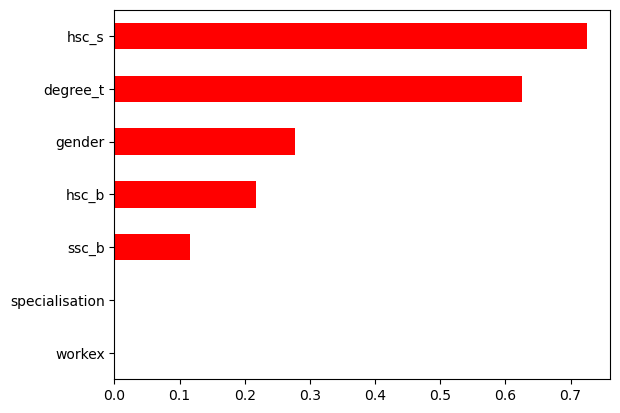

In [59]:
chi2_scores.plot(kind='barh',color='red');

In [60]:
pd.Series(chi2scores[0],index=cx.columns).sort_values()

hsc_s             0.124
degree_t          0.239
gender            1.179
hsc_b             1.523
ssc_b             2.481
specialisation   11.343
workex           31.390
dtype: float64

### As per chi2-test, p-values of `workex` & `specialisation` are less than 0.05 which lead to the rejection of null hypothesis (Null hypothesis states that the variable is not important in the prediction) for these two variables. Hence, concluding that as per chi2-test, `workex` & `specialisation` are important variables in the predicting the target variable

### 2. Information gain (for all types of variables)

In [61]:
mutualinfoscores=mutual_info_classif(x_scaled,y_scaled)

In [62]:
pd.Series(mutualinfoscores,x_scaled.columns).sort_values()

gender           0.000
hsc_s            0.009
degree_t         0.010
etest_p          0.022
hsc_b            0.043
specialisation   0.068
ssc_b            0.074
workex           0.083
mba_p            0.096
degree_p         0.168
hsc_p            0.181
ssc_p            0.312
dtype: float64

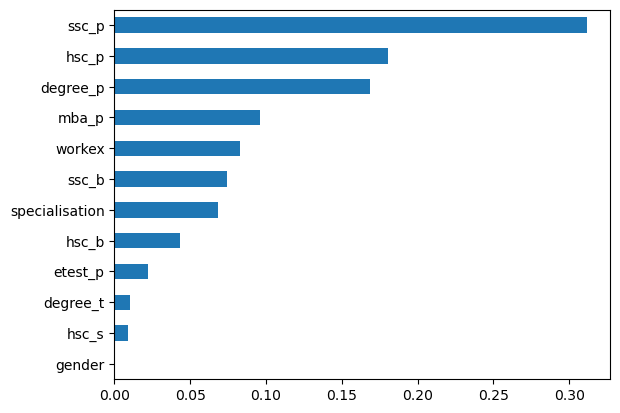

In [63]:
pd.Series(mutualinfoscores,x_scaled.columns).sort_values().plot(kind='barh');

### As per information gain, ssc_p, hsc_p, degree_p & workex are the most important variables

### 3. Correlation Matrix (for numerical variables only)

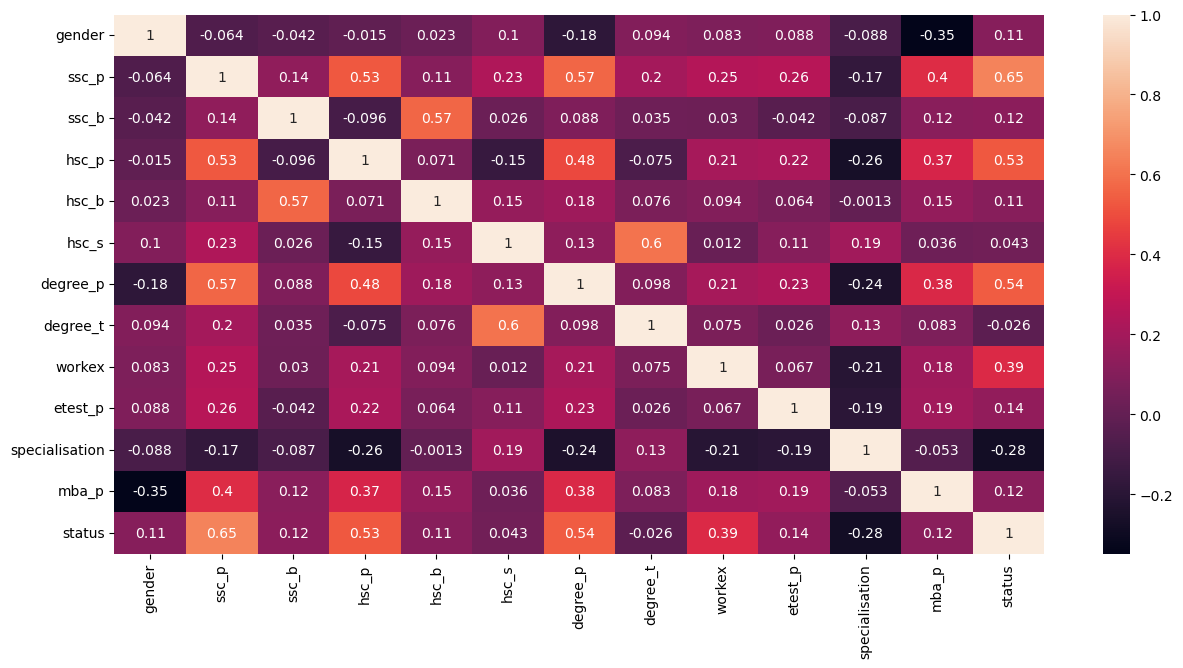

In [64]:
plt.figure(figsize=(15,7))
sns.heatmap(pd.concat([x_scaled,y_scaled],axis=1).corr(),annot=True);

### As per correlation matrix, we can conclude that `ssc_p`, `hsc_p`, `degree_p` & `workex` are important variables & `degree_t` & `hsc_b` are least important in predicting the `status`

## So, combining the results of various feature selection techniques, we can conclude that `degree_t`,`hsc_s`,`ssc_b` & `hsc_b` are least important variables for prediction. So, we can go ahead & drop them from the dataset

In [66]:
# Dropping the above variables from x_train & x_test
x_train.drop(columns=['degree_t','hsc_s','ssc_b','hsc_b'],inplace=True)
x_test.drop(columns=['degree_t','hsc_s','ssc_b','hsc_b'],inplace=True)

### Model building & Evaluation

###  1. Logistic Regression - Baseline model

In [67]:
logregmodel=LogisticRegression().fit(x_train,y_train)

In [68]:
logregpred=logregmodel.predict(x_test)

In [69]:
print(metrics.classification_report(y_test,logregpred))

              precision    recall  f1-score   support

           0       0.71      0.77      0.74        13
           1       0.90      0.87      0.88        30

    accuracy                           0.84        43
   macro avg       0.81      0.82      0.81        43
weighted avg       0.84      0.84      0.84        43



In [70]:
metrics.roc_auc_score(y_test,logregpred)

0.8179487179487179

In [78]:
logregtrainpred=logregmodel.predict(x_train)

In [79]:
# Testing on training dataset to see if it is overfitting
metrics.roc_auc_score(y_train,logregtrainpred)

0.8686440677966102

### As we can notice here the difference in the auc_score, we can conclude that there's no overfitting here

### As per this baseline model of logistic regression, for a given datapoint, there is a 74% probabilty that the model predicts correctly

### Logistic Regression - Hyperparameter tuned

In [71]:
param_grid={'C':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]}

In [72]:
gs=GridSearchCV(LogisticRegression(),param_grid=param_grid,cv=5,scoring='accuracy').fit(x_train,y_train)

In [73]:
gs.best_params_

{'C': 1.0}

### As we know that the default value of C is 1.0 which is what is the baseline model built on. Hence, not proceeding further with this

### KNearestNeighbors - Baseline model

In [74]:
knnmodel=KNeighborsClassifier().fit(x_train,y_train)

In [75]:
knnpred=knnmodel.predict(x_test)

In [76]:
print(metrics.classification_report(y_test,knnpred))

              precision    recall  f1-score   support

           0       0.53      0.77      0.62        13
           1       0.88      0.70      0.78        30

    accuracy                           0.72        43
   macro avg       0.70      0.73      0.70        43
weighted avg       0.77      0.72      0.73        43



In [77]:
metrics.roc_auc_score(y_test,knnpred)

0.7346153846153846

### As per this KNN model, given the data point, there's a 73% proability that the model predicts correctly

### KNearestNeighbors - Hyperparameter tuned

In [80]:
param_grid={'n_neighbors':[4,5,6,7]}

In [81]:
gs=GridSearchCV(KNeighborsClassifier(),param_grid=param_grid,cv=5,scoring='accuracy').fit(x_train,y_train)

In [82]:
gs.best_params_

{'n_neighbors': 5}

### As we know that the default value of n_neighbors is 5 & the baseline model was built on default value i.e. with 5 neighbors itself. So, ignoring the further steps of proceeding with this hyperparameter tuned model

### Cross-validation to check the performance of the model 

In [83]:
crossvalscore=cross_val_score(LogisticRegression(),x_scaled,y_scaled,cv=5,scoring='f1_macro')

In [84]:
np.mean(crossvalscore)

0.8842864968616684

### Model indeed is performing well on various folds of the dataset.
## Out of Logistic Regression & KNN, Baseline Logistic Regression is the best performer. Hence, finalizing this model for further steps

## Model Interpretability using SHAP Analysis

In [86]:
model = LogisticRegression()
model.fit(x_train, y_train)

LogisticRegression()

In [87]:
explainer=shap.Explainer(model,x_train,feature_names=x_train.columns)

In [88]:
shap.initjs()

In [89]:
shapvalues=explainer.shap_values(x_test)

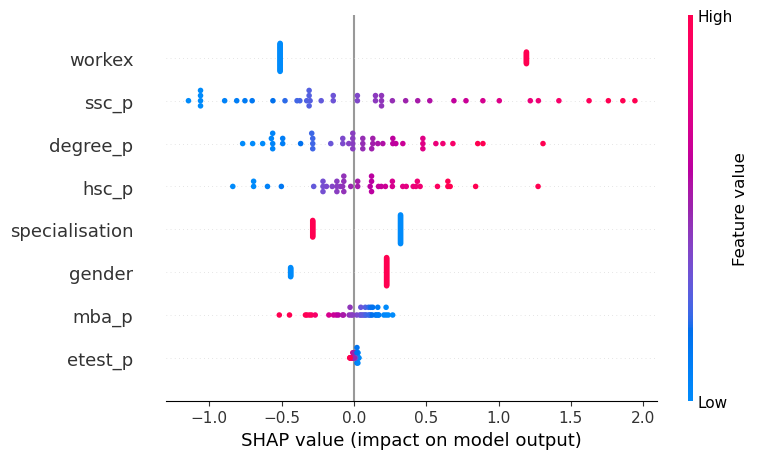

In [91]:
shap.summary_plot(shapvalues,x_test,feature_names=x_test.columns)

## Insights from the model
## 1. 'workex' plays the important role in prediction. Higher the value of 'workex' more is the probability of getting placed.
## 2. 'ssc_p' is also important in prediction. Higher the value of 'ssc_p' more is the probability of getting placed.
## 3. Similar trend for 'degree_p' & 'hsc_p' i.e. higher values for these, higher are the chances of getting placed.
## 4. There are other smaller takeaways from the model however these are considered not so important.

## Recommendations for the college
## 1. College needs to focus more on 'specialisation' i.e. 'Marketing&HR' are less likely to get placed. So, the management needs to put in efforts in understanding the concerns on why they are not able to make it. Some RCA needs to be done to check this. Put more attention for these students to ensure they are trained well & providing support.
## 2. College needs to focus on female students to get them placed.